# Four in one plot

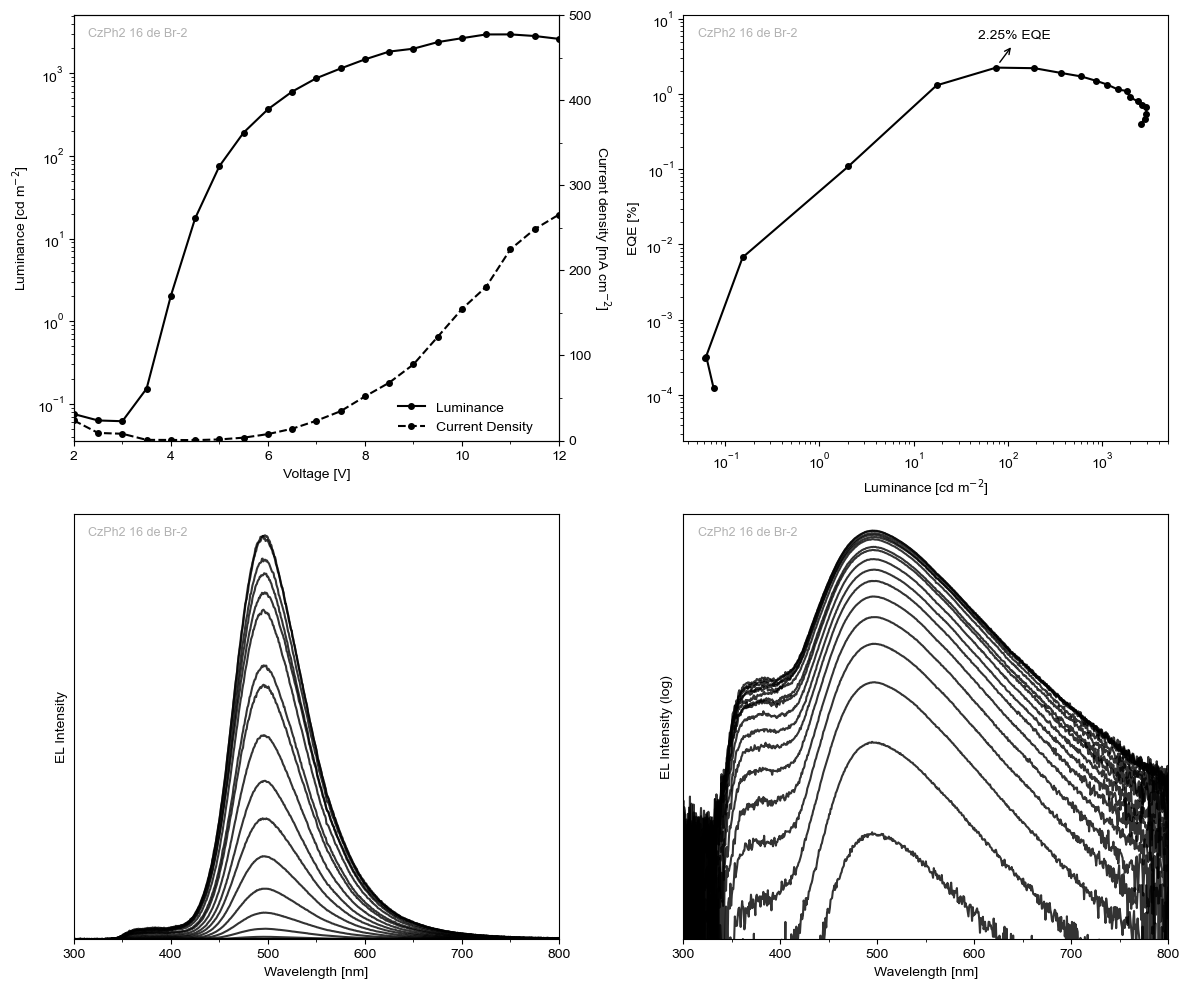

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Set plot font
plt.rcParams["font.family"] = "Arial"  # Set global font to Arial


# Updated File Path
file_path = "/Users/yachall007/polybox/Shared/MALDI_TOF/LED device data/CzPh2 16 de Br-2.xlsx"

# Extract compound name
import os
compound_name = os.path.splitext(os.path.basename(file_path))[0]

# Load the Excel file
df = pd.read_excel(file_path, sheet_name=0, header=None, engine='openpyxl')

### PART 1: Extract Voltage-Based Data ###
# Locate Voltage-based data start
start_row_voltage = df[df.iloc[:, 0].astype(str).str.contains("Voltage \\[V\\]", case=False, na=False)].index
if len(start_row_voltage) == 0:
    raise ValueError("Could not find 'Voltage [V]' in the first column.")
start_row_voltage = start_row_voltage[0]

# Locate where Wavelength data starts
start_row_wavelength = df[df.iloc[:, 0].astype(str).str.contains("Wavelength \\[nm\\]", case=False, na=False)].index
if len(start_row_wavelength) == 0:
    raise ValueError("Could not find 'Wavelength [nm]' in the first column.")
start_row_wavelength = start_row_wavelength[0] - 2  # Stop two rows before Wavelength

# Extract Voltage-based data
df_voltage = pd.read_excel(file_path, sheet_name=0, skiprows=start_row_voltage, nrows=start_row_wavelength - start_row_voltage, engine='openpyxl')
df_voltage = df_voltage.dropna(axis=1, how='all')  # Drop empty columns

# Define voltage-based columns
x1, y1, y2 = "Voltage [V]", "Luminance [cd/m2]", "Current density [mA/cm2]"
x3, y3 = "Luminance [cd/m2]", "EQE [%]"

### PART 2: Extract Wavelength-Based Data ###
start_row_wavelength = start_row_wavelength + 2  # Fix the previous mistake
df_wavelength = pd.read_excel(file_path, sheet_name=0, skiprows=start_row_wavelength, engine='openpyxl')
df_wavelength = df_wavelength.dropna(axis=1, how='all')

# Define wavelength-based columns
wavelength = df_wavelength.iloc[:, 0]
el_intensities = df_wavelength.iloc[:, 1:]

# **Ensure numeric values in el_intensities**
el_intensities = el_intensities.apply(pd.to_numeric, errors='coerce')
el_intensities = el_intensities.dropna(axis=1, how='all')
el_intensities = el_intensities.dropna(axis=0, how='any')

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

### PLOT 1: Luminance & Current Density vs. Voltage (Top Left) ###
ax1 = axes[0, 0]

# Primary y-axis (Luminance - log scale)
line1, = ax1.plot(df_voltage[x1], df_voltage[y1], marker='o', linestyle='-', markersize=4, color='black', label="Luminance")
ax1.set_xlabel(x1)
ax1.set_ylabel("Luminance [cd m$^{-2}$]")
ax1.set_yscale("log")
ax1.set_xlim(2, 12)

# Secondary y-axis (Current Density - linear scale)
ax2 = ax1.twinx()
line2, = ax2.plot(df_voltage[x1], df_voltage[y2], marker='o', linestyle='--', markersize=4, color='black', label="Current Density")  
ax2.set_ylabel("Current density [mA cm$^{-2}$]", rotation=270, labelpad=15)
ax2.set_ylim(0, 500)

# **Add secondary ticks (every 10 units) on the linear y-axis**
ax2.yaxis.set_minor_locator(MultipleLocator(50))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

# Floating legend
fig.legend([line1, line2], ["Luminance", "Current Density"], loc="upper left",
           bbox_to_anchor=(0.325, 0.605), frameon=True, framealpha=0)




### PLOT 2: EQE vs. Luminance (Log-log) (Top Right) ###
ax3 = axes[0, 1]

# Find the max and min EQE values
max_idx = df_voltage[y3].idxmax()
min_idx = df_voltage[y3].idxmin()
max_luminance = df_voltage[x3].iloc[max_idx]
max_eqe = df_voltage[y3].iloc[max_idx]
min_eqe = df_voltage[y3].iloc[min_idx]

# Plot data
ax3.plot(df_voltage[x3], df_voltage[y3], marker='o', linestyle='-', markersize=4, color='black')
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Luminance [cd m$^{-2}$]")
ax3.set_ylabel(y3)

# Adjust y-limits dynamically
margin_factor = 5
y_min = min_eqe / margin_factor
y_max = max_eqe * margin_factor
ax3.set_ylim(y_min, y_max)

# Arrow position (angled up & right)
arrow_x = max_luminance * 1.5
arrow_y = max_eqe * 2
arrow_base_x = max_luminance * 1.05
arrow_base_y = max_eqe * 1.1

ax3.annotate("", xy=(arrow_x, arrow_y), xytext=(arrow_base_x, arrow_base_y),
             arrowprops=dict(arrowstyle="->", lw=1, mutation_scale=10, color='black'))

# Annotation placement
text_offset_x = arrow_x * 1.05
text_offset_y = arrow_y * 1.25
ax3.text(text_offset_x, text_offset_y, f"{max_eqe:.2f}% EQE", fontsize=10, color='black', ha="center")

### PLOT 3: EL Intensity vs. Wavelength (Overlayed) (Bottom Left) ###
ax4 = axes[1, 0]

# Overlay all intensity columns in black
for col in el_intensities.columns:
    ax4.plot(wavelength, el_intensities[col], linestyle='-', alpha=0.8, color='black')

ax4.set_xlabel("Wavelength [nm]")
ax4.set_ylabel("EL Intensity")
ax4.set_yticks([])  # Remove y-axis ticks
ax4.set_xlim(300, 800)
ax4.set_ylim(0, None)

# **Add secondary ticks (every 10 nm) on the x-axis**
ax4.xaxis.set_minor_locator(MultipleLocator(50))

### PLOT 4: EL Intensity vs. Wavelength (Semi-log) (Bottom Right) ###
ax5 = axes[1, 1]

# Determine max value dynamically for better stretching
Y_MAX = el_intensities.max().max() * 1.5

# Overlay all intensity columns in black
for col in el_intensities.columns:
    ax5.semilogy(wavelength, el_intensities[col], linestyle='-', alpha=0.8, color='black')

ax5.set_xlabel("Wavelength [nm]")
ax5.set_ylabel("EL Intensity (log)")
ax5.set_xlim(300, 800)
ax5.set_ylim(1e-2, Y_MAX)

# **Remove all y-axis ticks and tick marks**
ax5.set_yticks([])  
ax5.tick_params(axis='y', which='both', length=0)  # Removes tick marks

# **Add secondary ticks (every 10 nm) on the x-axis**
ax5.xaxis.set_minor_locator(MultipleLocator(50))

# Add floating text to each plot
for ax in [ax1, ax3, ax4, ax5]:  # Only add to primary axes, not twin axes
    ax.text(0.03, 0.97, compound_name, transform=ax.transAxes,
            fontsize=9, color='black', alpha=0.3, ha="left", va="top")

# Adjust spacing between subplots
plt.tight_layout()

# Show the complete figure
plt.show()


# Save figure
figurename = f"{compound_name}_EL"
fig.savefig(f"{figurename}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{figurename}.svg", dpi=300, bbox_inches="tight")

